<a href="https://colab.research.google.com/github/sahandv/DemoProjects/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Cloud

In [ ]:
# datapath = '/home/sahand/GoogleDrive/Data/' # Local
datapath = 'drive/My Drive/Data/' # Remote https://drive.google.com/drive/folders/1fUb_p8RyYuKQ--Efr0vFZaojnulCPYT3?usp=sharing

In [ ]:
# NOT REQUIRED. Unless want to save model to drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install natsort numpy optuna pandas matplotlib seaborn tqdm scikit-learn keras emd

## Import


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
# from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.callbacks import ModelCheckpoint
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Dropout,LSTM,Activation,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D,Flatten,Bidirectional
# from keras.optimizers import Adam
from math import sqrt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
from numpy.random import seed
import pandas as pd
from datetime import datetime
from google.colab import files as clf
import emd

seed(50)

import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import keras


def data_reshape_lstm(data_in):
    data_list = []
    for c in tqdm(np.array(data_in.columns)):
        data_col = data_in[c].values
        data_col.reshape((len(data_col), 1))
        data_list.append(data_col)
    data_array = np.array(data_list)
    return data_array

def target_generator(input,num_steps=5):
    from tqdm import tqdm
    import numpy as np

    output = []
    for idx,val in tqdm(enumerate(input)):
      output.append(input[idx:idx+num_steps])
    output=np.array(output)
    return output

def plot_graphs(history, string,save_str=''):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.savefig(save_str+'.png')
  plt.show()


## Prepare data


## Init

In [ ]:
path = datapath+'lstm' # remote
!ls '{path}'

dataset_upscaled_size.eps  Lintrn.txt  Nomtrn.txt  Notrn.txt  results


In [ ]:
experiment_id = 3.1
unscale = True
sample_file_name = 'Notrn.txt'
sample_frequency = 'lf'
draw_data = False
columns = ['raw','hf','lf']

# SECT 1

### Read from file

In [ ]:
if draw_data:
    fig, ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24), (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4,sharex='all',sharey=False,figsize=(12,9))
    files = ['Notrn.txt','Lintrn.txt','Nomtrn.txt']
    data_raw = pd.read_csv(os.path.join(path,files[0]))
    data_raw.columns = ['raw','hf','lf']
    ax11.plot(data_raw['raw'],linewidth=0.05)
    ax12.plot(data_raw['hf'],linewidth=0.05)
    ax13.plot(data_raw['lf'],linewidth=1)
    data_raw = pd.read_csv(os.path.join(path,files[1]))
    data_raw.columns = ['raw','hf','lf','trend']
    ax21.plot(data_raw['raw'],linewidth=0.05)
    ax22.plot(data_raw['hf'],linewidth=0.05)
    ax23.plot(data_raw['lf'],linewidth=1)
    ax24.plot(data_raw['trend'],linewidth=1)
    data_raw = pd.read_csv(os.path.join(path,files[2]))
    data_raw.columns = ['raw','hf','lf','trend']
    ax31.plot(data_raw['raw'],linewidth=0.05)
    ax32.plot(data_raw['hf'],linewidth=0.05)
    ax33.plot(data_raw['lf'],linewidth=1)
    ax34.plot(data_raw['trend'],linewidth=1)

    ax11.set_title('Input Data')
    ax12.set_title('High Frequency')
    ax13.set_title('Low Frequency')
    ax14.set_title('Trend')

    plt.setp(ax11, ylabel='A')
    plt.setp(ax21, ylabel='B')
    plt.setp(ax31, ylabel='C')

    plt.savefig(os.path.join(path,'dataset_upscaled_size.eps'), format='eps')
    clf.download(os.path.join(path,'dataset_upscaled_size.eps'))

          raw        hf       lf
0     0.20828 -0.100600  0.25142
1     0.23413 -0.067155  0.26019
2     0.43148  0.137850  0.26896
3     0.39268  0.106800  0.27773
4     0.34814  0.070061  0.28651
...       ...       ...      ...
2869  0.23580 -0.057916  0.39102
2870  0.21368 -0.046943  0.37919
2871  0.22854  0.000749  0.36726
2872  0.31310  0.117970  0.35526
2873  0.41121  0.248660  0.34323

[2874 rows x 3 columns]


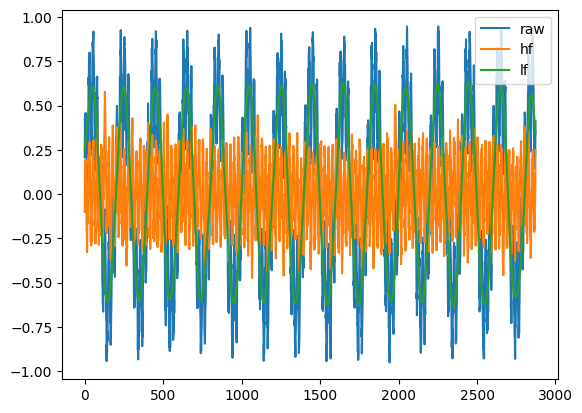

In [ ]:
n_steps = 1
data_raw = pd.read_csv(os.path.join(path,sample_file_name))
data_raw.columns = columns
data_raw.plot()
print(data_raw)
#Option 1: Go with the original data prediction
# data_clean = pd.DataFrame(data_raw['raw'])

#Option 2: Go with the hf prediction alone
data_clean = pd.DataFrame(data_raw[sample_frequency])

data_clean.columns = ['raw']

### Configuration

In [ ]:
n_outputs = 1 # Number of steps to predict for multistep (output)
n_input = 100 # Number of input steps

day_to_train = int(data_clean.shape[0]*0.7) # Train on 70% of data
day_to_test = -(n_outputs+1)

In [ ]:
print(day_to_train,day_to_test)

2011 -2


### Preparation

In [ ]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data_clean.values)
data_clean['raw'] = x_scaled

In [ ]:
# data_clean = data_clean[['close-gold','average-gold']]
n_features = data_clean.shape[1]

# Separate data
train= data_clean[:day_to_train]
test = data_clean[day_to_train-n_outputs:day_to_test] # we need overlap here for multi-step, because otherwise the historical data will be wasted for test
draw = data_clean[day_to_train-n_outputs:day_to_test+n_outputs]

In [ ]:
future_predict_data = data_clean[-n_input:].values
# future_predict_data = np.expand_dims(future_predict_data,axis=0)

In [ ]:
# Prepare x and y for training
y_column = 'raw'

x_train = train.values
y_train = train[y_column].values
y_train_ms = target_generator(data_clean[y_column].values,n_outputs)[:day_to_train]

x_test = test.values
y_test = test[y_column].values
y_test_ms = target_generator(data_clean[y_column].values,n_outputs)[day_to_train-n_outputs:day_to_test]

2874it [00:00, 1090405.22it/s]
2874it [00:00, 1197539.21it/s]


In [ ]:
# save GT to disk
test_GT = min_max_scaler.inverse_transform(np.expand_dims(y_test,axis=1)[100:])
pd.DataFrame(test_GT,columns=['GT']).to_csv('drive/MyDrive/Data/lstm/results/'+sample_file_name+'_'+sample_frequency+'- GT.csv',index=False,header=False)

In [ ]:
# Preapare data generators
# Reshape input
# y_train_s = pd.Series(y_train)
# y_train = y_train_s.shift(-forecast+1).values # Shift

draw = draw[y_column].values
draw = draw[:-1]
 #x_train.shape[1]
train_data_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=n_input,stride=1, batch_size=32)
test_data_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=n_input,stride=1, batch_size=32)


In [ ]:
# make a list of train data to bypass generator
y_all_train = []
x_all_train = []
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    y_all_train.append(y)
    x_all_train.append(x)

In [ ]:
# make a list of test data to bypass generator
y_all_test = []
x_all_test = []
for i in range(len(test_data_gen)):
    x, y = test_data_gen[i]
    y_all_test.append(y)
    x_all_test.append(x)

In [ ]:
x_all_train = np.concatenate(x_all_train, axis=0)
y_all_train = np.concatenate(y_all_train, axis=0)
x_all_test = np.concatenate(x_all_test, axis=0)
y_all_test = np.concatenate(y_all_test, axis=0)

In [ ]:
print(day_to_train-n_outputs,day_to_test+n_outputs)

2010 -1


In [ ]:
y_all_train.shape

(1911,)

## Single Step - Select model


In [ ]:
dirName = os.path.join(path,'prediction','single-step')
#make the dir if not exist
try:
    os.makedirs(dirName)
    print('created path:',dirName)
except:
    print('path exists')


created path: drive/My Drive/Data/lstm/prediction/single-step


In [ ]:
model_type = 'LSTM'
if experiment_id==2:
    # Prepare model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=100,input_shape=(n_input,n_features),return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Dense(1))
    # model.add(Activation('sigmoid'))

    # ADAM = Adam(0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

if experiment_id==3:
    # Prepare model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=100,input_shape=(n_input,n_features),return_sequences=False))
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Dense(1))

    # ADAM = Adam(0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()


if experiment_id==3.1:
    # Prepare model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=50,input_shape=(n_input,n_features),return_sequences=False))
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Dense(1))

    # ADAM = Adam(0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,601 (60.94 KB)

 Trainable params: 15,601 (60.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_type = 'BILSTM'
# Prepare model
if experiment_id==4:
    input = tf.keras.Input(shape=(None,100,), dtype="float32",name='input_1')
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True))(input)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100))(x)
    x = tf.keras.layers.Dense(100)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

if experiment_id==5:
    input = tf.keras.Input(shape=(None,100,), dtype="float32",name='input_1')
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True))(input)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100))(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.Dense(100)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

if experiment_id==6:
    input = tf.keras.Input(shape=(None,100,), dtype="float32",name='input_1')
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True))(input)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100))(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.Dense(100)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

if experiment_id==7:
    input = tf.keras.Input(shape=(None,100,), dtype="float32",name='input_1')
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=False))(input)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.Dense(100)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

In [ ]:
model_type = 'CNN'
# Prepare model
if experiment_id==8:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=250,kernel_size=25,activation='relu',input_shape=(n_input,n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    model.add(tf.keras.layers.Conv1D(filters=50,kernel_size=3,activation='relu')) # 128 neurons with kernel size of 5 words
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

if experiment_id==9:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=100,kernel_size=25,activation='relu',input_shape=(n_input,n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
    model.add(tf.keras.layers.Conv1D(filters=50,kernel_size=3,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()

if experiment_id==10:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=100,kernel_size=3,activation='relu',input_shape=(n_input,n_features)))
    model.add(tf.keras.layers.Conv1D(filters=100,kernel_size=8,activation='relu',input_shape=(n_input,n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))# model.add(LSTM(units=200))
    model.add(tf.keras.layers.Conv1D(filters=75,kernel_size=5,activation='relu',input_shape=(n_input,n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))# model.add(LSTM(units=200))
    model.add(tf.keras.layers.Conv1D(filters=50,kernel_size=3,activation='relu'))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    # model.add(tf.keras.layers.LSTM(units=200))
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary()



# model = Sequential()
# # Encoder
# model.add(Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(n_input,n_features)))
# model.add(Conv1D(filters=200, kernel_size=3, activation='relu'))
# # model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(RepeatVector(n_outputs))
# # Decoder
# model.add(LSTM(100, activation='relu', return_sequences=True))
# # model.add(Dropout(0.1))
# model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss='mse', optimizer='adam')
# model.summary()

## Train

created path: drive/My Drive/Data/lstm/prediction/single-step
Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0587
Epoch 1: val_loss improved from inf to 0.00176, saving model to drive/My Drive/Data/lstm/prediction/single-step/ts-model-epoch:001-val-loss:0.001762.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0565 - val_accuracy: 0.0026 - val_loss: 0.0018
Epoch 2/300
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0013
Epoch 2: val_loss improved from 0.00176 to 0.00042, saving model to drive/My Drive/Data/lstm/prediction/single-step/ts-model-epoch:002-val-loss:0.000424.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0013 - val_accuracy: 0.0026 - val_loss: 4.2428e-04
Epoch 3/300
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 2.9272e-04
Epoch 3: val_loss improved from 0.00042 to 0.00028, saving model to drive/My Drive/Data/lstm/prediction/single-step/ts-model-epoch:003-val-loss:0.000277.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9m

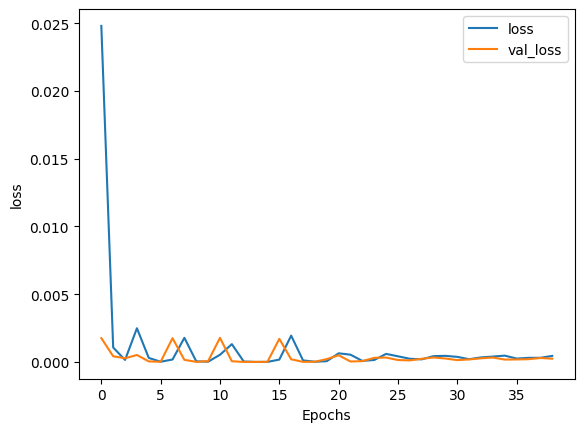

In [ ]:
# Train
os.makedirs(dirName,exist_ok=True)
os.makedirs('drive/MyDrive/Data/lstm/results/train plots/')
print('created path:',dirName)
checkpoint = tf.keras.callbacks.ModelCheckpoint(dirName+'/ts-model-epoch:{epoch:03d}-val-loss:{val_loss:05f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25)

history = model.fit(train_data_gen,
                            validation_data=test_data_gen, callbacks=[checkpoint,callback],
                            epochs=300,verbose=1,shuffle=False)
plot_graphs(history,'loss',save_str='drive/MyDrive/Data/lstm/results/train plots/'+str(experiment_id)+'_'+sample_file_name+'_'+sample_frequency)

## Test & Visualize

In [ ]:
list_of_files = glob.glob(dirName+'/*.h5') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

drive/My Drive/Data/lstm/prediction/single-step/ts-model-epoch:014-val-loss:0.000006.h5


In [ ]:
# load model
# model_name = dirName+'/ts-model-epoch:009-val-loss:0.488986.h5'
model_name = latest_file
# dirName = datapath+'covid19/multi-step/SE/N22-2 no-covid'
# model_name = dirName+'/covinomic-model-epoch:094-val-loss:0.000609.h5'
model = tf.keras.models.load_model(model_name)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,603 (60.95 KB)

 Trainable params: 15,601 (60.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
trainPredict = model.predict(train_data_gen)
testPredict = model.predict(test_data_gen)
testGT = np.expand_dims(y_test,axis=1)[100:]


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


#### Get errors

In [ ]:
# print each sample
y_all = []
x_all = []
for i in range(len(test_data_gen)):
    x, y = test_data_gen[i]
    y_all.append(y)
    x_all.append(x)
    # print('%s => %s' % (x, y))
# y_all

In [ ]:
if unscale:
    testGT = min_max_scaler.inverse_transform(testGT)
    testPredict = min_max_scaler.inverse_transform(testPredict)
    x_test = min_max_scaler.inverse_transform(x_test)
    draw = min_max_scaler.inverse_transform(np.expand_dims(draw,1))[:,0]

In [ ]:
testPredict_reshaped = testPredict[:,0]
testGT_reshaped = testGT[:,0]
# testGT_reshaped = np.expand_dims(np.array(y_all).squeeze(),axis=1) # makes sense, but not needed. Will handle it by itself

In [ ]:
# Get errors for all prediction days
mse = model.evaluate(test_data_gen)
rmse = np.sqrt(np.mean((testPredict_reshaped-testGT_reshaped)**2))
mae = metrics.mean_absolute_error(testGT_reshaped,testPredict_reshaped)
# msle = metrics.mean_squared_log_error(testGT_reshaped, testPredict_reshaped)
r2 = metrics.r2_score(testGT_reshaped, testPredict_reshaped)
# accuracy = (1-(np.abs(testPredict_reshaped - testGT_reshaped)/testGT_reshaped)).mean() #Not advised for continuous values

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0026 - loss: 8.6737e-06


In [ ]:
assert testPredict_reshaped.shape==testGT_reshaped.shape, "Oh no! Dimensions are not matching and the comparison is not valid!"

In [ ]:
print('RMSE',str(rmse)[:7])
print('MSE avg',np.array(mse).mean())
# print('MSE day one',str(np.array(mse)[0])[:7])
print('MAE',str(mae)[:7])
# print('MSLE',str(msle)[:7])
print('R2',str(r2)[:7])
# print('ACC',str(accuracy)[:7])

RMSE 0.00324
MSE avg 0.0013155815199752396
MAE 0.00268
R2 0.99994


#### Plot test

In [ ]:
from google.colab import files
preds = testPredict[:,0]
preds = [
        'RMSE: '+str(rmse)[:7],
        'MSE avg: '+str(np.array(mse).mean()),
        'MAE: '+str(mae)[:7],
        # 'MSLE: '+str(msle)[:7],
        'R2: '+str(r2)[:7],
         '',
        'Predictions'
]+list(preds)
pd.DataFrame(preds,columns=['predictions']).to_csv('drive/MyDrive/Data/lstm/results/'+str(experiment_id)+'_'+sample_file_name+'_'+sample_frequency+'- test results.csv',index=False,header=False)
# files.download('drive/MyDrive/Data/HHT/'+str(experiment_id)+'_'+sample_file_name+'_'+sample_frequency+'- test results.csv')

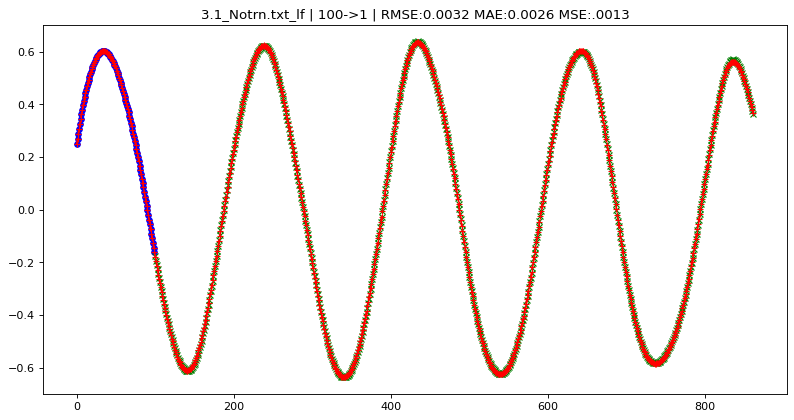

In [ ]:
os.makedirs('drive/MyDrive/Data/lstm/test plots/')
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(0,n_input), x_test[:100,0], 'bo--', linewidth=2, markersize=5)
for i in range(0,testGT_reshaped.shape[0]):
    # plt.plot(range(i+n_input,i+n_outputs+n_input), y_all[i][0], 'bo--', linewidth=2, markersize=5)
    plt.plot(range(i+n_input,i+n_outputs+n_input), testPredict[i], 'gx--', linewidth=2, markersize=5)
plt.plot(draw,'r+--')
plt.plot([0],'w.')
plt.title(str(experiment_id)+'_'+sample_file_name+'_'+sample_frequency+' | '+str(n_input)+"->"+str(n_outputs)+" | RMSE:"+str(rmse)[:6]+" MAE:"+str(mae)[:6]+" MSE:"+str(np.array(mse).mean())[1:6])
plt.savefig('drive/MyDrive/Data/lstm/test plots/'+str(experiment_id)+'_'+sample_file_name+'_'+sample_frequency+'.png')
plt.show()

# SECT 1 Output

In [ ]:
print('RMSE',str(rmse)[:7])
print('MSE avg',np.array(mse).mean())
# print('MSE day one',str(np.array(mse)[0])[:7])
print('MAE',str(mae)[:7])
# print('MSLE',str(msle)[:7])
print('R2',str(r2)[:7])
# print('ACC',str(accuracy)[:7])

RMSE 0.00324
MSE avg 0.0013155815199752396
MAE 0.00268
R2 0.99994


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,603 (60.95 KB)

 Trainable params: 15,601 (60.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# SECT 2

## Multi Step

In [ ]:
dirName = path+'prediction/multi-step/SE/model'

#### Bidirectional

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(200, input_shape=(n_steps,n_features), return_sequences=True)))
model.add(TimeDistributed(Dense(200, activation='sigmoid')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

ValueError: ignored

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(n_steps, n_features)))
model.add(TimeDistributed(Dense(200, activation='sigmoid')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 1, 200)            81600     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 1, 200)            40200     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 1, 1)              201       
_________________________________________________________________
dense_40 (Dense)             (None, 1, 1)              2         
Total params: 122,003
Trainable params: 122,003
Non-trainable params: 0
_________________________________________________________________


#### Series

In [ ]:
# Prepare model
model = Sequential()
model.add(LSTM(units=100,input_shape=(n_input,n_features),return_sequences=True))
# model.add(LSTM(units=200,return_sequences=True))
model.add(LSTM(units=100)) # add or remove this to have a parallel LSTM, but if did, suggest using time distributed layers
model.add(Dropout(0.1))
model.add(Dense(100))
model.add(Dense(n_outputs))
# model.add(Activation('sigmoid'))

# ADAM = Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 131,401
Trainable params: 131,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_input

100

In [ ]:
n_outputs

1

In [ ]:
n_features

1

#### Encoder / Decoder

In [ ]:
model = Sequential()
# Encoder
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(RepeatVector(n_outputs))
# Decoder
model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(100, activation='relu')))
# model.add(Dropout(0.1))
# model.add(TimeDistributed(Dense(30)))
model.add(TimeDistributed(Dense(1)))
# model.add(Activation('sigmoid'))

# ADAM = Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
# model.compile(loss='mean_squared_error', optimizer=ADAM, metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam')
# model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

model.summary()

#### ED BD

In [ ]:
model = Sequential()
# Encoder
model.add(Bidirectional(LSTM(300, activation='relu'), input_shape=(n_input, n_features)))
model.add(RepeatVector(n_outputs))
# Decoder
model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(LSTM(200, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(150, activation='relu')))
# model.add(TimeDistributed(Dense(30)))
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mse', optimizer='adam')

model.summary()

#### CNN LSTM

In [ ]:
model = Sequential()
# Encoder
model.add(Conv1D(filters=100, kernel_size=3, activation='relu', input_shape=(n_input,n_features)))
model.add(Conv1D(filters=200, kernel_size=3, activation='relu'))
# model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
# Decoder
model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 98, 100)           400       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 200)           60200     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 200)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9600)              0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 9600)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            3880400   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 100)           

#### CONV LSTM

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_input, 1, n_length, n_features)))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

#### Train

In [ ]:
# Train
try:
    os.makedirs(dirName)
    print('created path:',dirName)
except:
    print('path exists')
checkpoint = ModelCheckpoint(dirName+'/sine-model-epoch:{epoch:03d}-val-loss:{val_loss:05f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

history = model.fit(train_data_gen,
                            validation_data=test_data_gen, callbacks=[checkpoint,callback],
                            epochs=300,verbose=1,shuffle=False)
plot_graphs(history,'loss')
model.summary()

path exists
Epoch 1/300
 279/1999 [===>..........................] - ETA: 7:30 - loss: 0.5511 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored